<a href="https://www.kaggle.com/code/animesh0955/brain-tumer-detection?scriptVersionId=287229731" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [2]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 6.0 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.2

In [3]:
import tensorflow as tf

2025-12-19 09:50:36.614981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766137837.099540      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766137837.222177      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    image_size = (224,224),
    batch_size=32,
    seed=123,
    validation_split=.2,
    subset='training',
    labels='inferred',
    label_mode='int'
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1766137877.598206      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766137877.598780      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    image_size = (224,224),
    batch_size=32,
    seed=123,
    validation_split=.2,
    subset='validation',
    labels='inferred',
    label_mode='int'
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [6]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size=(224,224),
    batch_size=32,
    shuffle=False
)

Found 1311 files belonging to 4 classes.


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,797,380 (56.45 MB)

 Trainable params: 82,692 (323.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras", 
    monitor="val_accuracy",          
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

callbacks=[checkpoint, early_stop]

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
history = model.fit(train_dataset, validation_data=validation_dataset, callbacks=callbacks, epochs=10)

Epoch 1/10


I0000 00:00:1766137886.329517     123 service.cc:148] XLA service 0x7b695000e7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766137886.331042     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766137886.331060     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766137886.877858     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/143 ━━━━━━━━━━━━━━━━━━━━ 32:39 14s/step - accuracy: 0.1250 - loss: 1.4876

I0000 00:00:1766137898.345464     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5624 - loss: 0.9939
Epoch 1: val_accuracy improved from -inf to 0.85377, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 59s 317ms/step - accuracy: 0.5634 - loss: 0.9920 - val_accuracy: 0.8538 - val_loss: 0.4173
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8415 - loss: 0.4120
Epoch 2: val_accuracy improved from 0.85377 to 0.86953, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.8416 - loss: 0.4118 - val_accuracy: 0.8695 - val_loss: 0.3983
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8680 - loss: 0.3418
Epoch 3: val_accuracy improved from 0.86953 to 0.87040, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - accuracy: 0.8680 - loss: 0.3418 - val_accuracy: 0.8704 - val_loss: 0.4085
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8741 - loss: 0.3286
Epoch 4: val_accuracy did not impro

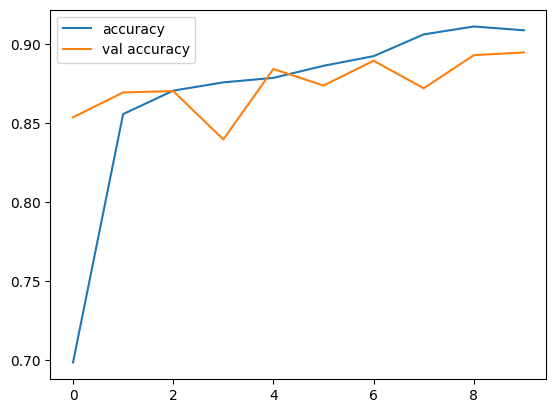

In [15]:
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()

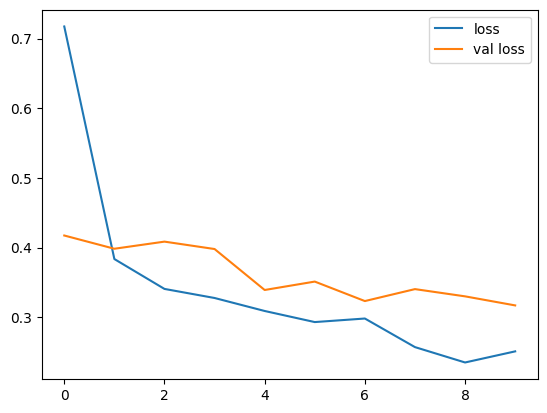

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

# Fine tuning 

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [18]:
for layer in base_model.layers[:14]:
    layer.trainable=False

for layer in base_model.layers[14:]:
    layer.trainable=True

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,797,380 (56.45 MB)

 Trainable params: 7,162,116 (27.32 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_finetuned_model.keras", 
    monitor="val_accuracy",          
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

callbacks=[checkpoint, early_stop]

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, validation_data=validation_dataset, callbacks=callbacks, epochs=10)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5115 - loss: 1.0760
Epoch 1: val_accuracy improved from -inf to 0.86515, saving model to best_finetuned_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.5127 - loss: 1.0738 - val_accuracy: 0.8651 - val_loss: 0.4007
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8544 - loss: 0.3786
Epoch 2: val_accuracy improved from 0.86515 to 0.88529, saving model to best_finetuned_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.8546 - loss: 0.3784 - val_accuracy: 0.8853 - val_loss: 0.3137
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9030 - loss: 0.2514
Epoch 3: val_accuracy improved from 0.88529 to 0.92907, saving model to best_finetuned_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.9031 - loss: 0.2512 - val_accuracy: 0.9291 - val_loss: 0.2093
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9382 - loss: 0

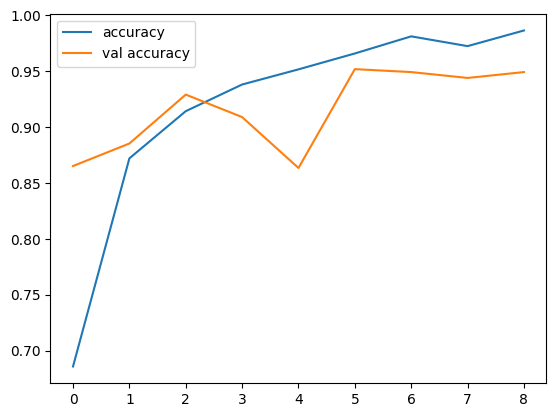

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()

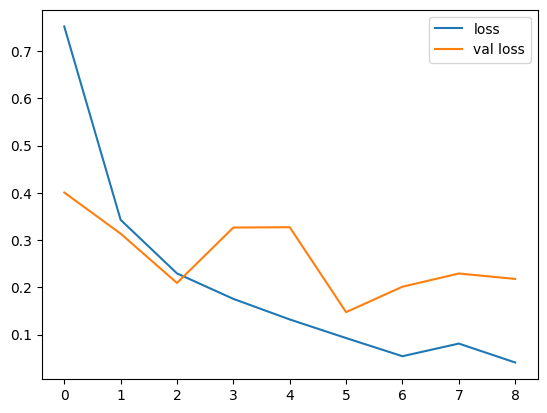

In [24]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

In [25]:
import numpy as np 
y_prob = model.predict(test_dataset)
y_pred = np.argmax(y_prob, axis=1)

y_test_true = np.concatenate([y for x,y in test_dataset], axis=0)

41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step


In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
cm = confusion_matrix(y_test_true, y_pred)

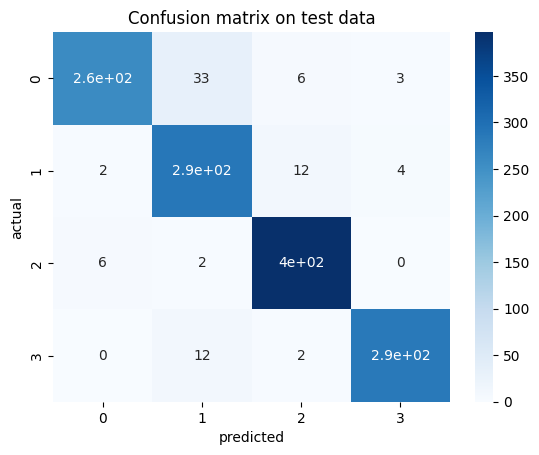

In [28]:
import seaborn as sns
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion matrix on test data')
plt.show()

In [29]:
model.evaluate(test_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9041 - loss: 0.2269


[0.17793872952461243, 0.9374523162841797]

# ROC Curve

In [30]:
from tensorflow.keras.utils import to_categorical

y_true_oh = to_categorical(y_test_true, num_classes=4)

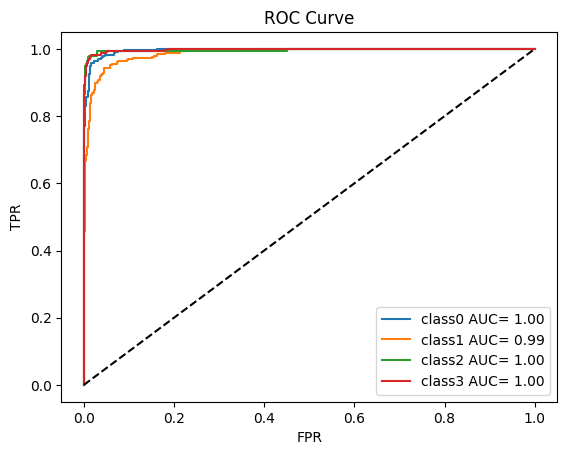

In [31]:
from sklearn.metrics import roc_curve, auc

for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_oh[:,i], y_prob[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'class{i} AUC={roc_auc: .2f}')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

# Precision Recall Curve

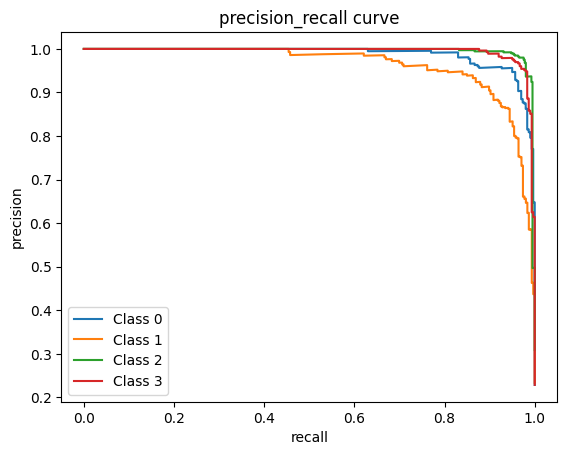

In [32]:
from sklearn.metrics import precision_recall_curve

for i in range(4):
    precision, recall, _ = precision_recall_curve(y_true_oh[:, i],y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision_recall curve')
plt.legend()